In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

file_paths = {
    'Benin': '../data/benin-malanville.csv',
    'Sierra Leone': '../data/sierraleone-bumbuna.csv',
    'Togo': '../data/togo-dapaong_qc.csv'
}

metrics = ['GHI', 'DNI', 'DHI']

# Set a plotting style for better aesthetics
plt.style.use('ggplot')

In [2]:
# Load Data
all_countries_data = []
for country, path in file_paths.items():
    try:
        df = pd.read_csv(path)
        df['Country'] = country # Add a 'Country' column to identify the origin of the data
        all_countries_data.append(df)
        print(f"Successfully loaded data for {country} from {path}")
    except FileNotFoundError:
        print(f"Error: File not found for {country} at {path}. Please ensure all CSV files are in the correct location.")
        continue
    except Exception as e:
        print(f"An error occurred while loading data for {country} from {path}: {e}")
        continue

# Concatenate all dataframes if any data was loaded
if not all_countries_data:
    print("No data was loaded. Please check file paths and ensure files exist.")
    combined_df = pd.DataFrame() # Create an empty DataFrame to avoid errors later
else:
    combined_df = pd.concat(all_countries_data, ignore_index=True)
    print("\nCombined Data Head (first 5 rows):")
    print(combined_df.head())
    print(f"\nCombined DataFrame shape: {combined_df.shape}")

Successfully loaded data for Benin from ../data/benin-malanville.csv
Successfully loaded data for Sierra Leone from ../data/sierraleone-bumbuna.csv
Successfully loaded data for Togo from ../data/togo-dapaong_qc.csv

Combined Data Head (first 5 rows):
          Timestamp  GHI  DNI  DHI  ModA  ModB  Tamb    RH   WS  WSgust  \
0  2021-08-09 00:01 -1.2 -0.2 -1.1   0.0   0.0  26.2  93.4  0.0     0.4   
1  2021-08-09 00:02 -1.1 -0.2 -1.1   0.0   0.0  26.2  93.6  0.0     0.0   
2  2021-08-09 00:03 -1.1 -0.2 -1.1   0.0   0.0  26.2  93.7  0.3     1.1   
3  2021-08-09 00:04 -1.1 -0.1 -1.0   0.0   0.0  26.2  93.3  0.2     0.7   
4  2021-08-09 00:05 -1.0 -0.1 -1.0   0.0   0.0  26.2  93.3  0.1     0.7   

   WSstdev     WD  WDstdev   BP  Cleaning  Precipitation  TModA  TModB  \
0      0.1  122.1      0.0  998         0            0.0   26.3   26.2   
1      0.0    0.0      0.0  998         0            0.0   26.3   26.2   
2      0.5  124.6      1.5  997         0            0.0   26.4   26.2   
3 

In [3]:
# Metric Comparison: Summary Table
print("\n--- Summary Statistics (Mean, Median, Std Dev) by Country ---")
if not combined_df.empty and not combined_df[metrics].empty:
    summary_table = combined_df.groupby('Country')[metrics].agg(['mean', 'median', 'std'])
    print(summary_table)
else:
    print("Cannot generate summary table: combined DataFrame is empty or missing required metric columns.")


--- Summary Statistics (Mean, Median, Std Dev) by Country ---
                     GHI                            DNI                     \
                    mean median         std        mean median         std   
Country                                                                      
Benin         240.559452    1.8  331.131327  167.187516   -0.1  261.710501   
Sierra Leone  201.957515    0.3  298.495150  116.376337   -0.1  218.652659   
Togo          230.555040    2.1  322.532347  151.258469    0.0  250.956962   

                     DHI                     
                    mean median         std  
Country                                      
Benin         115.358961    1.6  158.691074  
Sierra Leone  113.720571   -0.1  158.946032  
Togo          116.444352    2.5  156.520714  



--- Generating Boxplots for GHI, DNI, DHI ---


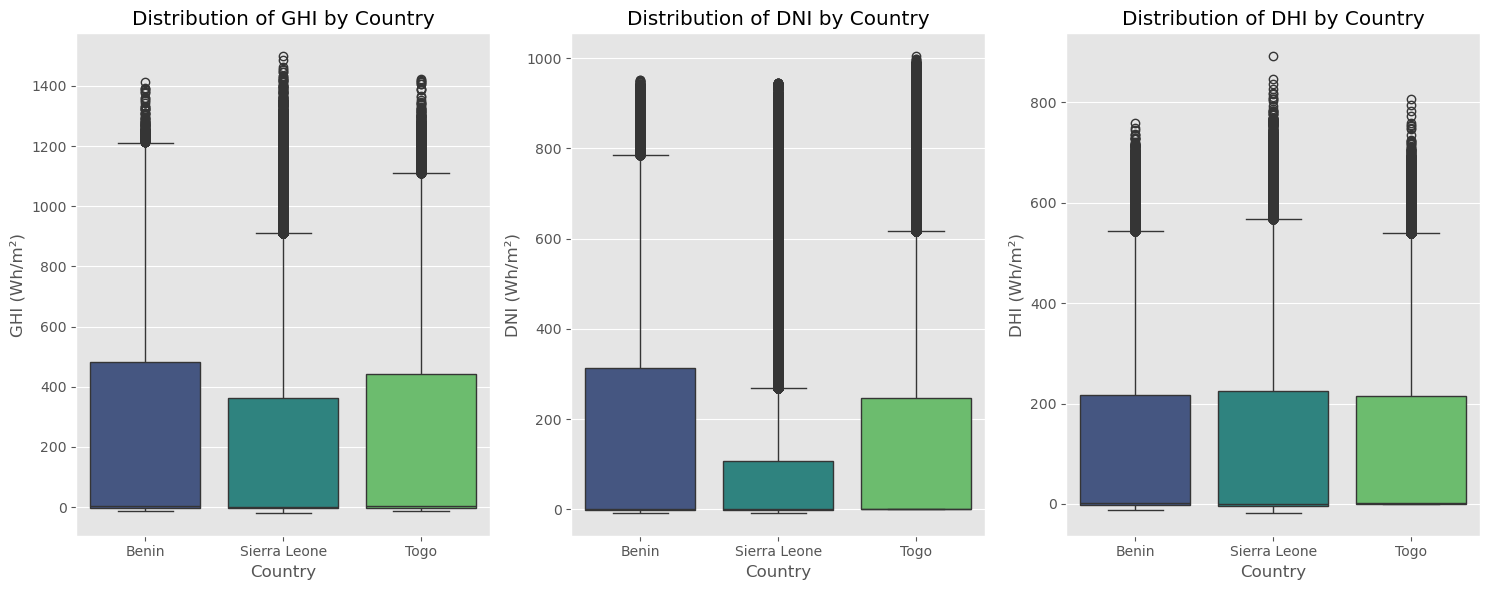

In [4]:
# Metric Comparison: Boxplots
print("\n--- Generating Boxplots for GHI, DNI, DHI ---")
if not combined_df.empty and 'Country' in combined_df.columns:
    fig, axes = plt.subplots(1, len(metrics), figsize=(5 * len(metrics), 6), sharey=False)

    if len(metrics) == 1:
        axes = [axes]

    for i, metric in enumerate(metrics):
        if metric in combined_df.columns:
            sns.boxplot(x='Country', y=metric, data=combined_df, ax=axes[i], palette='viridis', hue='Country', legend=False)
            axes[i].set_title(f'Distribution of {metric} by Country')
            axes[i].set_ylabel(f'{metric} (Wh/m²)') 
        else:
            axes[i].set_title(f"'{metric}' column not found")
            print(f"Warning: Column '{metric}' not found in the combined dataset. Skipping boxplot for {metric}.")

    plt.tight_layout()
    plt.show()
else:
    print("Cannot generate boxplots: combined DataFrame is empty or 'Country' column is missing.")

In [5]:
# Statistical Testing: One-Way ANOVA on GHI ---
print("\n--- Performing Statistical Testing (One-Way ANOVA on GHI) ---")
if 'GHI' in combined_df.columns and combined_df['Country'].nunique() > 1:
    ghi_data_for_anova = [combined_df[combined_df['Country'] == country]['GHI'].dropna() for country in combined_df['Country'].unique()]

    ghi_data_for_anova = [g for g in ghi_data_for_anova if len(g) > 1] # ANOVA requires at least 2 data points per group

    if len(ghi_data_for_anova) > 1: # ANOVA requires at least 2 groups
        f_statistic, p_value_anova = stats.f_oneway(*ghi_data_for_anova)
        print(f"One-Way ANOVA Results for GHI:")
        print(f"  F-statistic: {f_statistic:.2f}")
        print(f"  P-value: {p_value_anova:.4f}")

        alpha = 0.05 
        if p_value_anova < alpha:
            print(f"  Conclusion: With a p-value ({p_value_anova:.4f}) less than the significance level ({alpha}), we reject the null hypothesis.")
            print("  There are statistically significant differences in the mean GHI among the countries.")
        else:
            print(f"  Conclusion: With a p-value ({p_value_anova:.4f}) greater than the significance level ({alpha}), we fail to reject the null hypothesis.")
            print("  There are no statistically significant differences in the mean GHI among the countries.")
    else:
        print("Not enough valid GHI data or countries (at least 2 with data) to perform ANOVA.")
else:
    print("Skipping statistical testing: 'GHI' column not found or less than two unique countries in the dataset.")


--- Performing Statistical Testing (One-Way ANOVA on GHI) ---
One-Way ANOVA Results for GHI:
  F-statistic: 2090.09
  P-value: 0.0000
  Conclusion: With a p-value (0.0000) less than the significance level (0.05), we reject the null hypothesis.
  There are statistically significant differences in the mean GHI among the countries.



--- Generating Bar Chart for Average GHI by Country ---

Average GHI (Wh/m²) by Country (ranked):
Country
Benin           240.559452
Togo            230.555040
Sierra Leone    201.957515
Name: GHI, dtype: float64


/tmp/ipykernel_11949/1025535686.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_ghi_by_country.index, y=avg_ghi_by_country.values, palette='plasma')


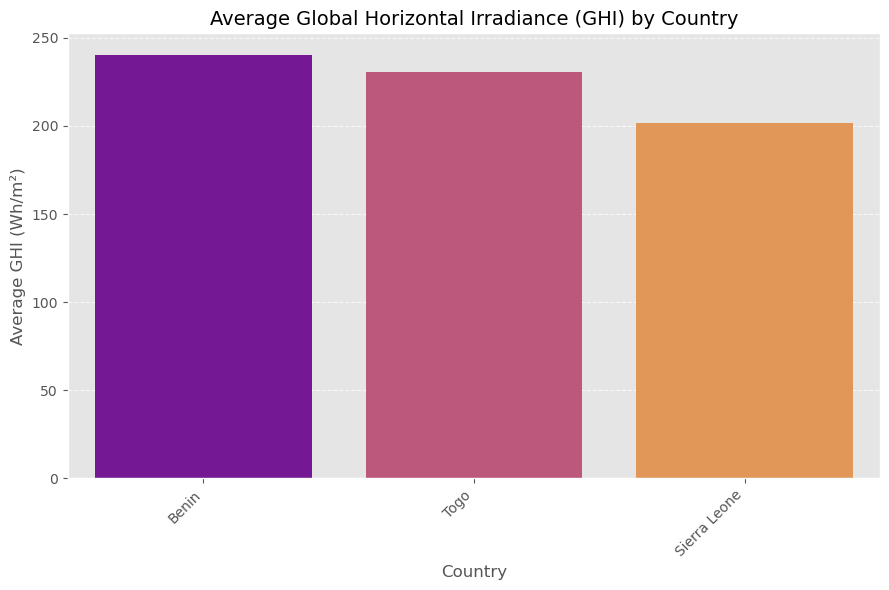

In [6]:
# (Bonus) Visual Summary: Average GHI Bar Chart
print("\n--- Generating Bar Chart for Average GHI by Country ---")
if 'GHI' in combined_df.columns:
    avg_ghi_by_country = combined_df.groupby('Country')['GHI'].mean().sort_values(ascending=False)
    print("\nAverage GHI (Wh/m²) by Country (ranked):")
    print(avg_ghi_by_country)

    plt.figure(figsize=(9, 6)) # Increased figure size for better readability
    sns.barplot(x=avg_ghi_by_country.index, y=avg_ghi_by_country.values, palette='plasma')
    plt.title('Average Global Horizontal Irradiance (GHI) by Country', fontsize=14)
    plt.xlabel('Country', fontsize=12)
    plt.ylabel('Average GHI (Wh/m²)', fontsize=12)
    plt.xticks(rotation=45, ha='right', fontsize=10) # Rotate labels for readability
    plt.yticks(fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7) # Add grid for easier reading
    plt.tight_layout()
    plt.show()
else:
    print("Cannot generate average GHI bar chart: 'GHI' column not found in the combined dataset.")